In [2]:
import gym
import time
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use('ggplot')

torch.manual_seed(42)
random.seed(42)

# set the GPU
device = torch.device("cuda:0")

## Double DQN with experience replay

epoch:   0 	 epsilon: 0.712, total frames: 15, mean return last 100 episodes: 15.00
Elapsed time:  00:00:00


/home/rob/.conda/envs/meta/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 100 	 epsilon: 0.020, total frames: 2378, mean return last 100 episodes: 23.63
Elapsed time:  00:00:04
epoch: 200 	 epsilon: 0.020, total frames: 21667, mean return last 100 episodes: 192.89
Elapsed time:  00:00:45
epoch: 300 	 epsilon: 0.020, total frames: 47507, mean return last 100 episodes: 258.40
Elapsed time:  00:01:38
epoch: 400 	 epsilon: 0.020, total frames: 80813, mean return last 100 episodes: 333.06
Elapsed time:  00:02:49




Average reward: 212.01
Average reward (last 100 episodes): 256.91


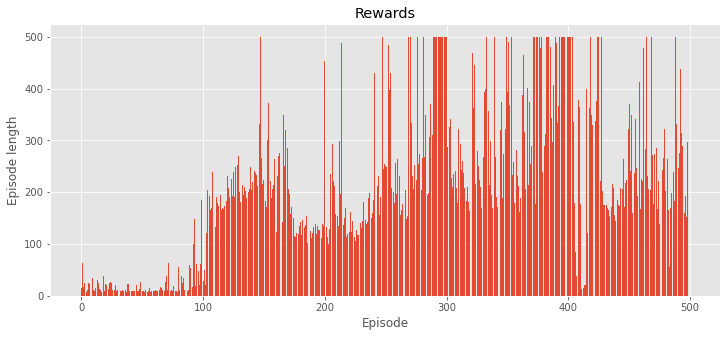

In [11]:
env = gym.make('CartPole-v1')
env.seed(42)

class NeuralNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_size=64):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(obs_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, act_dim)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x
    
class ExperienceReplay(object):
    """Memory for experience replay"""
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, obs, action, new_obs, reward, done):
        transition = (obs, action, new_obs, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else: 
            self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
    def __len__(self):
        return len(self.memory)
    
class DQN(object):
    def __init__(self, env, lr=0.01, gamma=0.99,
                 hidden_size=64, replay_size=int(1e4),
                 update_target_frequency=500):
        self.env = env
        obs_dim = env.observation_space.shape[0]
        act_dim = env.action_space.n
        
        self.gamma = gamma
        self.nn = NeuralNetwork(obs_dim, act_dim, 
                                hidden_size).to(device)
        self.target_nn = NeuralNetwork(obs_dim, 
                                       act_dim, hidden_size).to(device)
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=lr)
        
        # Memory for experience replay
        self.memory = ExperienceReplay(replay_size)
        
        # Decaying eps-greedy
        self.epsilon = 0.9
        self.epsilon_target = 0.02
        self.epsilon_decay = 500
        
        # Track when to update
        self.update_target_frequency = update_target_frequency
        self.update_target_counter = 0
        
    def select_action(self, obs):
        """Selects action from the learned Q-function
        """
        if torch.rand(1)[0] > self.epsilon:      
            with torch.no_grad():
                obs = torch.Tensor(obs).to(device)
                act = self.nn(obs)
                act = torch.max(act, 0)[1]
                act = act.item()        
        else:
            act = env.action_space.sample()
        return act
    
    def update(self, batch_size = 32):
        """Perform the update rule on the function approximator,
           the Neural Network
        """
        if (len(self.memory) < batch_size):
            return
        
        obs, action, new_obs, reward, done = self.memory.sample(batch_size)
        
        # Push tensors to device
        obs = torch.Tensor(obs).to(device)
        new_obs = torch.Tensor(new_obs).to(device)
        reward = torch.Tensor([reward]).to(device)
        action = torch.LongTensor(action).to(device)
        done = torch.Tensor(done).to(device)
        
        n_obs_indexes = self.nn(new_obs).detach()
        max_values_index = torch.max(n_obs_indexes, 1)[1]

        new_obs_values = self.target_nn(new_obs).detach()
        max_new_obs_values = new_obs_values.gather(1, 
                                                   max_values_index.unsqueeze(1)
                                                   ).squeeze(1)
            
        target_value = reward + (1 - done) * self.gamma * max_new_obs_values
        predicted_value = self.nn(obs).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        for param in self.nn.parameters():
            param.grad.data.clamp_(-1, 1)
            
        self.optimizer.step()
        
        if self.update_target_counter % self.update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        self.update_target_counter += 1

    def _calculate_epsilon(self, frames):
        self.epsilon = self.epsilon_target + (self.epsilon - self.epsilon_target) * \
                  np.exp(-1. * frames / self.epsilon_decay)
    
    def plot(self, steps_total, num_episodes):
        print("\n\n\n\nAverage reward: %.2f" % (sum(steps_total)/num_episodes))
        print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))
        
        plt.figure(figsize=(12,5))
        plt.title("Rewards")
        plt.ylabel("Episode length")
        plt.xlabel("Episode")
        plt.bar(torch.arange(len(steps_total)), steps_total)
        plt.show()
        
    def learn(self, num_episodes=500, report_interval=100):
        steps_total = []
        total_frames = 0 
        start_time = time.time()
        
        for i_episode in range(num_episodes):
            obs = self.env.reset()
            step = 0
            while True:
                # Increment counters
                step += 1
                total_frames += 1
                
                self._calculate_epsilon(total_frames)

                action = self.select_action(obs)
                new_obs, reward, done, _ = self.env.step(action)
                self.memory.push(obs, action, new_obs, reward, done)
                
                # Perform the update rule,
                self.update()
                obs = new_obs
                
                if done:
                    steps_total.append(step)
                    mean_reward_100 = sum(steps_total[-100:])/100
            
                    if (i_episode % report_interval == 0):
                        print('epoch: %3d \t epsilon: %.3f, total frames: %i, mean return last 100 episodes: %.2f' %
                          (i_episode, self.epsilon, total_frames, np.mean(steps_total[-100:])))

                        elapsed_time = time.time() - start_time
                        print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
                    break
            
        self.plot(steps_total, num_episodes)

agent = DQN(env)
agent.learn()